In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Business FS Bend Cable','FS','Financial Services Bus']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                   Queue  Forecasted_AHT  Forecasted_CV  \
0 2020-08-06 10:30:00  Business FS Bend Cable           384.0            1.0   
1 2020-08-06 10:45:00  Business FS Bend Cable           294.0            2.0   
2 2020-08-06 11:00:00  Business FS Bend Cable           370.0            1.0   

   Actual_AHT  Actual_CV  
0       715.0        2.0  
1       715.0        2.0  
2       697.0        1.0

In [3]:
# remove duplicated data
appended_data['Actual_CV'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Actual_CV'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Forecasted_CV'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Forecasted_CV'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Actual_AHT'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Actual_AHT'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Forecasted_AHT'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Forecasted_AHT'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

## Volume Forecasts

In [4]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 07:00:00        0.0
1 2017-01-02 07:15:00        0.0
2 2017-01-02 07:30:00        1.0

In [5]:
hourly_cv = grouped_cv.resample('1H', on='DateTime').sum()
hourly_cv.head(3)

Actual_CV
DateTime                      
2017-01-02 07:00:00        1.0
2017-01-02 08:00:00        4.0
2017-01-02 09:00:00        8.0

In [6]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 07:00:00            1.0
1 2017-01-02 07:15:00            1.0
2 2017-01-02 07:30:00            0.0

In [7]:
hourly_fcv = grouped_fcv.resample('1H', on='DateTime').sum()
hourly_fcv.head(3)

Forecasted_CV
DateTime                          
2017-01-02 07:00:00            3.0
2017-01-02 08:00:00            5.0
2017-01-02 09:00:00            5.0

In [8]:
hourly_cv.reset_index(inplace=True)
daily_cv = hourly_cv.resample('D', on='DateTime').sum()
daily_cv.head(3)

Actual_CV
DateTime             
2017-01-02       62.0
2017-01-03      193.0
2017-01-04      152.0

In [9]:
hourly_fcv.reset_index(inplace=True)
daily_fcv = hourly_fcv.resample('D', on='DateTime').sum()
daily_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02           52.0
2017-01-03          136.0
2017-01-04          136.0

In [10]:
daily_cv.reset_index(inplace=True)
weekly_cv = daily_cv.resample('W', label='left', on='DateTime').sum()
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23      718.0
2022-10-30      594.0
2022-11-06      134.0

In [11]:
daily_fcv.reset_index(inplace=True)
weekly_fcv = daily_fcv.resample('W', label='left', on='DateTime').sum()
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23          692.0
2022-10-30          624.0
2022-11-06          133.0

In [12]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds  for_y
303 2022-10-23  692.0
304 2022-10-30  624.0
305 2022-11-06  133.0

In [13]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds      y
303 2022-10-23  718.0
304 2022-10-30  594.0
305 2022-11-06  134.0

#### Initiate Prophet

In [14]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
407 2024-10-20  617.828223  507.199255  725.908544
408 2024-10-27  595.708248  478.640247  706.917940
409 2024-11-03  546.661646  438.125326  662.160080

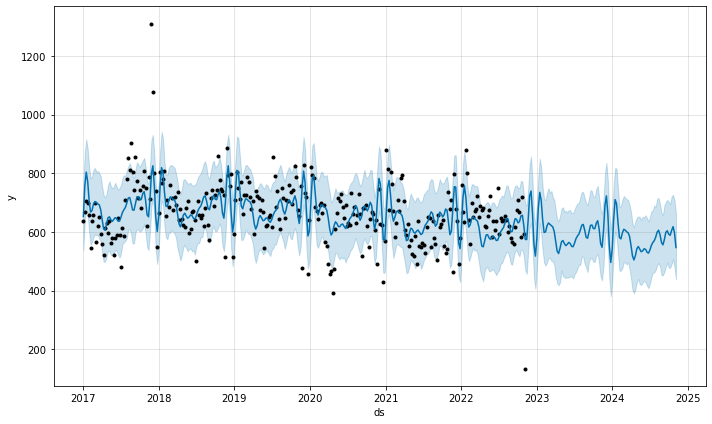

In [17]:
fig1 = m.plot(forecast)

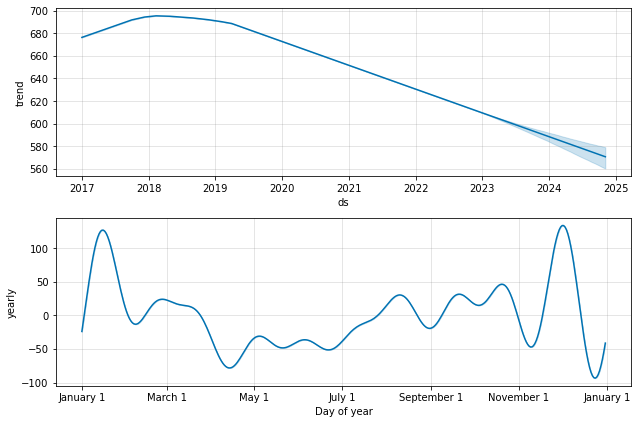

In [18]:
fig2 = m.plot_components(forecast)


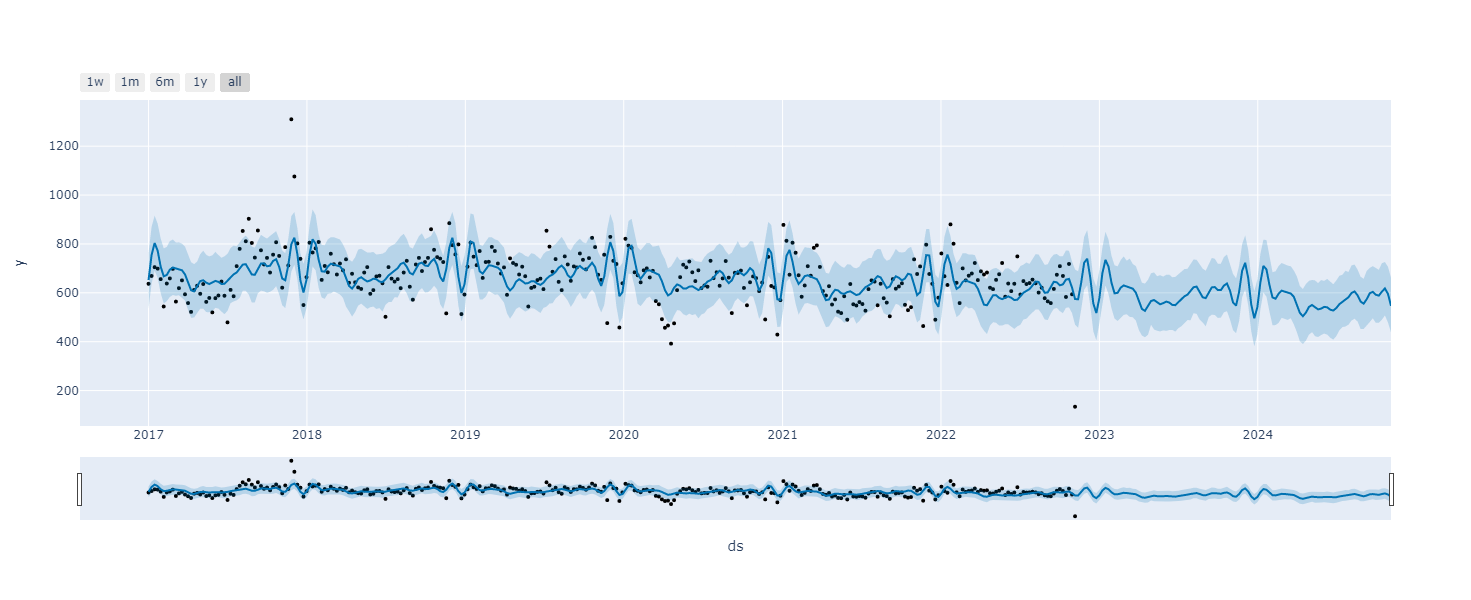

In [19]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

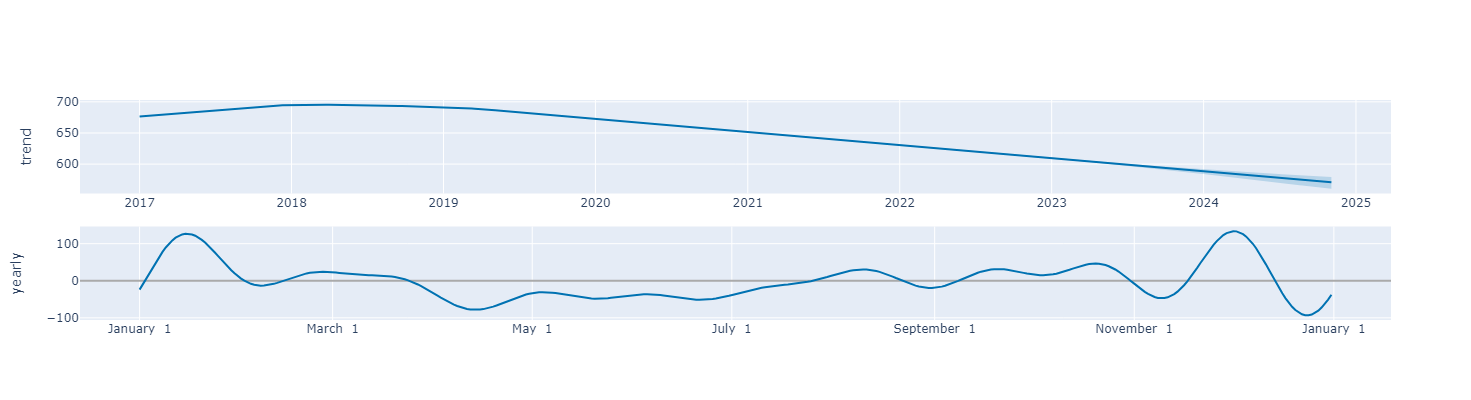

In [20]:
plot_components_plotly(m, forecast)


In [21]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
407 2024-10-20  571.517609  507.199255  725.908544   561.369216   579.723978   
408 2024-10-27  571.113599  478.640247  706.917940   560.853002   579.418117   
409 2024-11-03  570.709588  438.125326  662.160080   560.337622   579.142030   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
407       46.310614             46.310614             46.310614  46.310614   
408       24.594650             24.594650             24.594650  24.594650   
409      -24.047943            -24.047943            -24.047943 -24.047943   

     yearly_lower  yearly_upper  multiplicative_terms  \
407     46.310614     46.310614                   0.0   
408     24.594650     24.594650                   0.0   
409    -24.047943    -24.047943                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
407                         0.0                         0.0  617.828223  
408                         0.0                         0.0  595.708248  
409                         0.0                         0.0  546.661646

#### Cross Validation

In [22]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 2021-01-03  593.972537  502.777509  697.704166  878.0 2021-01-01
1 2021-01-10  693.745999  596.852064  787.407764  813.0 2021-01-01
2 2021-01-17  713.260588  624.412358  807.939868  674.0 2021-01-01

In [23]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  9177.214995  95.797782  73.537212  0.113383  0.096265  0.115650   
1  9 days  8607.698267  92.777682  76.993290  0.118098  0.109108  0.121290   
2 16 days  8229.407918  90.716084  71.009919  0.111540  0.096356  0.113512   

   coverage  
0  0.787234  
1  0.702128  
2  0.808511

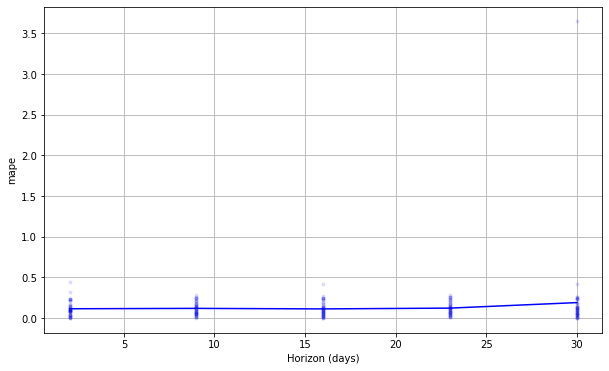

In [24]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [25]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [26]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-01-01  676.359082  536.590673  764.389662   676.359082   676.359082   
1   2017-01-08  676.756225  637.059242  870.241590   676.756225   676.756225   
2   2017-01-15  677.153369  690.723695  915.778230   677.153369   677.153369   
3   2017-01-22  677.550512  660.824779  882.921350   677.550512   677.550512   
4   2017-01-29  677.947655  598.899602  822.295456   677.947655   677.947655   
..         ...         ...         ...         ...          ...          ...   
405 2024-10-06  572.325630  477.610469  694.345148   562.504216   580.295717   
406 2024-10-13  571.921619  489.957662  721.363813   561.917363   580.044126   
407 2024-10-20  571.517609  507.199255  725.908544   561.369216   579.723978   
408 2024-10-27  571.113599  478.640247  706.917940   560.853002   579.418117   
409 2024-11-03  570.709588  438.125326  662.160080   560.337622   579.142030   

     additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0        -23.957204            -23.957204            -23.957204  -23.957204   
1         77.881111             77.881111             77.881111   77.881111   
2        126.699026            126.699026            126.699026  126.699026   
3         94.785328             94.785328             94.785328   94.785328   
4         28.444775             28.444775             28.444775   28.444775   
..              ...                   ...                   ...         ...   
405       16.102255             16.102255             16.102255   16.102255   
406       32.920748             32.920748             32.920748   32.920748   
407       46.310614             46.310614             46.310614   46.310614   
408       24.594650             24.594650             24.594650   24.594650   
409      -24.047943            -24.047943            -24.047943  -24.047943   

     ...  yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    ...    -23.957204                   0.0                         0.0   
1    ...     77.881111                   0.0                         0.0   
2    ...    126.699026                   0.0                         0.0   
3    ...     94.785328                   0.0                         0.0   
4    ...     28.444775                   0.0                         0.0   
..   ...           ...                   ...                         ...   
405  ...     16.102255                   0.0                         0.0   
406  ...     32.920748                   0.0                         0.0   
407  ...     46.310614                   0.0                         0.0   
408  ...     24.594650                   0.0                         0.0   
409  ...    -24.047943                   0.0                         0.0   

     multiplicative_terms_upper        yhat      y  for_y         Team  \
0                           0.0  652.401878  637.0  528.0  fs_business   
1                           0.0  754.637336  669.0  622.0  fs_business   
2                           0.0  803.852394  705.0  657.0  fs_business   
3                           0.0  772.335839  699.0  702.0  fs_business   
4                           0.0  706.392430  656.0  684.0  fs_business   
..                          ...         ...    ...    ...          ...   
405                         0.0  588.427884    NaN    NaN  fs_business   
406                         0.0  604.842367    NaN    NaN  fs_business   
407                         0.0  617.828223    NaN    NaN  fs_business   
408                         0.0  595.708248    NaN    NaN  fs_business   
409                         0.0  546.661646    NaN    NaN  fs_business   

    prophet_absolute_percent_error  verint_absolute_percent_error  
0                        -0.024179                       0.171115  
1                        -0.128008                       0.070254  
2                        -0.140216                       0.068085  
3                        -0.

In [27]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.10899877548217773 total seconds have elapsed.


## AHT Forecasts

In [28]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 07:00:00      0.0
1 2017-01-02 07:15:00      0.0
2 2017-01-02 07:30:00    467.0

In [29]:
hourly_aht = grouped_aht.resample('1H', on='DateTime').sum()
hourly_aht.head(3)

Adj_AHT
DateTime                    
2017-01-02 07:00:00    467.0
2017-01-02 08:00:00   2298.0
2017-01-02 09:00:00   2291.0

In [30]:
hourly_aht.reset_index(inplace=True)
daily_aht = hourly_aht.resample('D', on='DateTime').sum()
daily_aht.head(3)

Adj_AHT
DateTime           
2017-01-02  23493.0
2017-01-03  81666.0
2017-01-04  67288.0

In [31]:
daily_aht.reset_index(inplace=True)
weekly_aht = daily_aht.resample('W', label='left', on='DateTime').sum()
weekly_aht.tail(3)

Adj_AHT
DateTime            
2022-10-23  284594.0
2022-10-30  263839.0
2022-11-06   50941.0

In [32]:
weekly_cv.tail(3)

Actual_CV
DateTime             
2022-10-23      718.0
2022-10-30      594.0
2022-11-06      134.0

In [33]:
combined_aht = weekly_aht.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_aht['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
303 2022-10-23  396.370474
304 2022-10-30  444.173401
305 2022-11-06  380.156716

In [34]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 07:00:00    205.0
1 2017-01-02 07:15:00    273.0
2 2017-01-02 07:30:00      0.0

In [35]:
hourly_faht = grouped_for.resample('1H', on='DateTime').sum()
hourly_faht.head(3)

Adj_for
DateTime                    
2017-01-02 07:00:00    908.0
2017-01-02 08:00:00   1913.0
2017-01-02 09:00:00   1915.0

In [36]:
hourly_faht.reset_index(inplace=True)
daily_faht = hourly_faht.resample('D', on='DateTime').sum()
daily_faht.head(3)

Adj_for
DateTime           
2017-01-02  20977.0
2017-01-03  56329.0
2017-01-04  54648.0

In [37]:
daily_faht.reset_index(inplace=True)
weekly_faht = daily_faht.resample('W', label='left', on='DateTime').sum()
weekly_faht.tail(3)

Adj_for
DateTime            
2022-10-23  282348.0
2022-10-30  253306.0
2022-11-06   56095.0

In [38]:
weekly_fcv.tail(3)

Forecasted_CV
DateTime                 
2022-10-23          692.0
2022-10-30          624.0
2022-11-06          133.0

In [39]:
combined_for = weekly_faht.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_faht['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
303 2022-10-23  408.017341
304 2022-10-30  405.939103
305 2022-11-06  421.766917

#### Initiate Prophet

In [40]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
407 2024-10-20
408 2024-10-27
409 2024-11-03

In [42]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
407 2024-10-20  399.446047  365.954001  429.476396
408 2024-10-27  397.170924  364.341452  430.362038
409 2024-11-03  400.256424  368.153847  433.985929

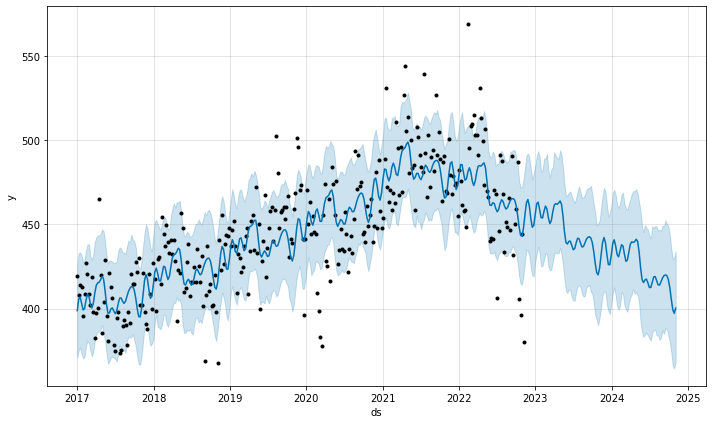

In [43]:
fig1 = m.plot(forecast)

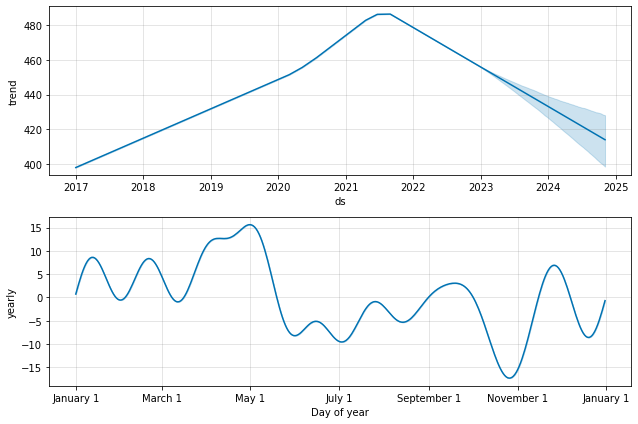

In [44]:
fig2 = m.plot_components(forecast)


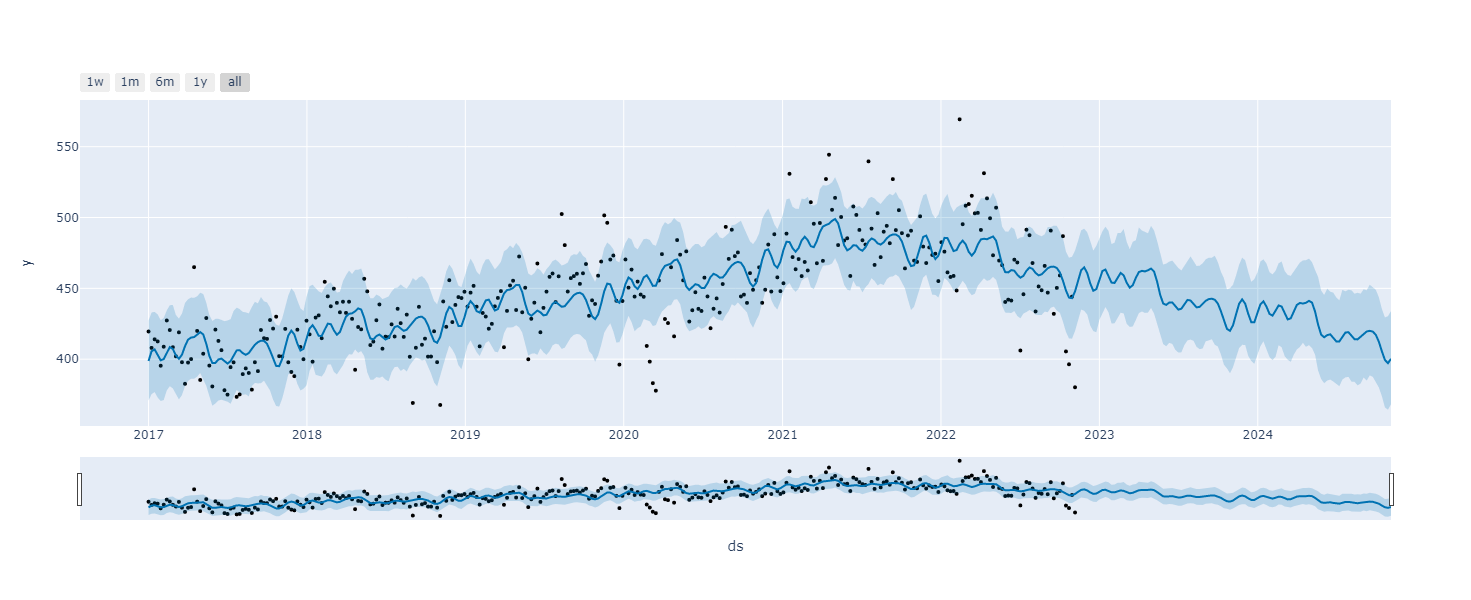

In [45]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

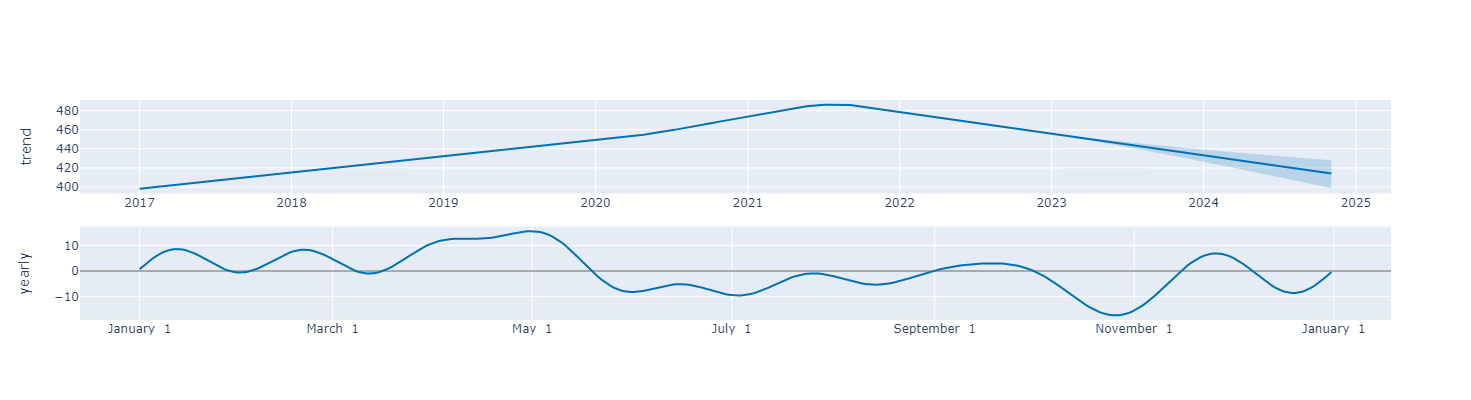

In [46]:
plot_components_plotly(m, forecast)


In [47]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
407 2024-10-20  414.878584  365.954001  429.476396   399.927934   428.582953   
408 2024-10-27  414.443511  364.341452  430.362038   399.280181   428.280615   
409 2024-11-03  414.008438  368.153847  433.985929   398.559484   428.103614   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
407      -15.432537            -15.432537            -15.432537 -15.432537   
408      -17.272587            -17.272587            -17.272587 -17.272587   
409      -13.752014            -13.752014            -13.752014 -13.752014   

     yearly_lower  yearly_upper  multiplicative_terms  \
407    -15.432537    -15.432537                   0.0   
408    -17.272587    -17.272587                   0.0   
409    -13.752014    -13.752014                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
407                         0.0                         0.0  399.446047  
408                         0.0                         0.0  397.170924  
409                         0.0                         0.0  400.256424

#### Cross Validate

In [48]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 47 forecasts with cutoffs between 2021-01-01 00:00:00 and 2022-10-07 00:00:00


  0%|          | 0/47 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-03  464.618403  439.154894  490.676352  453.604784 2021-01-01
1 2021-01-10  468.927636  443.201235  494.801470  488.642066 2021-01-01
2 2021-01-17  467.024226  439.720172  494.446195  530.842730 2021-01-01

In [49]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days   921.569270  30.357359  23.593579  0.048671  0.043531  0.048529   
1  9 days   930.890155  30.510493  23.654541  0.050646  0.039155  0.049533   
2 16 days  1102.380726  33.202119  26.146386  0.054642  0.049766  0.054101   

   coverage  
0  0.744681  
1  0.638298  
2  0.595745

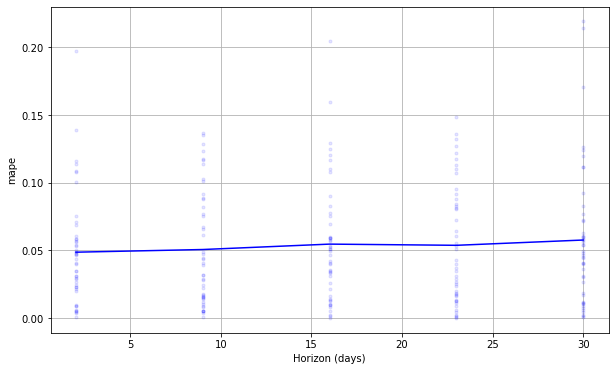

In [50]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [51]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    ("A1"."Team" = '{team}')'''

with ods as conn:
    conn.execute(delete)

In [52]:
forecast['prophet_absolute_percent_error'] = ((forecast['y'] - forecast['yhat']) / forecast['y'])
forecast['verint_absolute_percent_error'] = ((forecast['y'] - forecast['for_y']) / forecast['y'])
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-01-01  398.032057  370.805353  427.304943   398.032057   398.032057   
1   2017-01-08  398.355538  375.352827  432.988853   398.355538   398.355538   
2   2017-01-15  398.679019  376.805157  433.388422   398.679019   398.679019   
3   2017-01-22  399.002499  372.893141  431.612802   399.002499   399.002499   
4   2017-01-29  399.325980  370.494732  427.541472   399.325980   399.325980   
..         ...         ...         ...         ...          ...          ...   
405 2024-10-06  415.748730  380.022112  443.771932   401.078275   429.327317   
406 2024-10-13  415.313657  373.855782  435.485801   400.512514   429.046794   
407 2024-10-20  414.878584  365.954001  429.476396   399.927934   428.582953   
408 2024-10-27  414.443511  364.341452  430.362038   399.280181   428.280615   
409 2024-11-03  414.008438  368.153847  433.985929   398.559484   428.103614   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0          0.721046              0.721046              0.721046   0.721046   
1          7.245298              7.245298              7.245298   7.245298   
2          8.205103              8.205103              8.205103   8.205103   
3          3.993346              3.993346              3.993346   3.993346   
4         -0.143912             -0.143912             -0.143912  -0.143912   
..              ...                   ...                   ...        ...   
405       -3.415770             -3.415770             -3.415770  -3.415770   
406       -9.776699             -9.776699             -9.776699  -9.776699   
407      -15.432537            -15.432537            -15.432537 -15.432537   
408      -17.272587            -17.272587            -17.272587 -17.272587   
409      -13.752014            -13.752014            -13.752014 -13.752014   

     ...  yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    ...      0.721046                   0.0                         0.0   
1    ...      7.245298                   0.0                         0.0   
2    ...      8.205103                   0.0                         0.0   
3    ...      3.993346                   0.0                         0.0   
4    ...     -0.143912                   0.0                         0.0   
..   ...           ...                   ...                         ...   
405  ...     -3.415770                   0.0                         0.0   
406  ...     -9.776699                   0.0                         0.0   
407  ...    -15.432537                   0.0                         0.0   
408  ...    -17.272587                   0.0                         0.0   
409  ...    -13.752014                   0.0                         0.0   

     multiplicative_terms_upper        yhat           y       for_y  \
0                           0.0  398.753103  419.547881  406.634470   
1                           0.0  405.600836  407.988042  420.705788   
2                           0.0  406.884122  413.992908  456.569254   
3                           0.0  402.995846  412.542203  410.280627   
4                           0.0  399.182068  395.387195  407.991228   
..                          ...         ...         ...         ...   
405                         0.0  412.332960         NaN         NaN   
406                         0.0  405.536958         NaN         NaN   
407                         0.0  399.446047         NaN         NaN   
408                         0.0  397.170924         NaN         NaN   
409                         0.0  400.256424         NaN         NaN   

            Team prophet_absolute_percent_error  verint_absolute_percent_error  
0    fs_business                       0.049565                       0.030779  
1    fs_business                       0.005851                      -0.031172  
2    fs_business                       0.017171                      -0.102843  
3    fs_business        

In [53]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 410...Done. 0.08397436141967773 total seconds have elapsed.
